# Jackson Chumbler
## CS460G Assignment II
### I'm no Jupyter pro, so it's organized for you to run all cells, then scroll from the top. It gets a little weird if you try to change part I) stuff after running part II) code. My advice is to run all cells above the cell you modify. 
## Part I) Linear Regression with Gradient Descent
### Collect Data:

In [10]:
import pandas as pd
import numpy as np
df = pd.read_csv("./data/winequality-red.csv")

Given this linear regression with multiple x-terms, it may be difficult to determine good starting coefficients. 
### Test Prediction: 

In [11]:
def test_prediction(df: pd.DataFrame, coeffs):
    sum_of_difference = 0
    mean_squared_error = 0
    for i in range(df["quality"].values.size):
        true_qual = df["quality"].values[i]
        estimated_qual = 0  # calculate using all labels and coeffs
        for coef in coeffs:
            if coef[0] != 'b0':
                estimated_qual += coef[1] * df[coef[0]].values[i]
            else:
                estimated_qual += coef[1]  # offset
        sum_of_difference += (estimated_qual - true_qual)
        mean_squared_error += (estimated_qual - true_qual)**2
    mean_squared_error /= df["quality"].values.size
    avg_distance = sum_of_difference / df["quality"].values.size
    return avg_distance, mean_squared_error

In [12]:
sample_start_coeffs =  [['fixed acidity', 1], 
                        ['volatile acidity', 1], 
                        ['citric acid', 1], 
                        ['residual sugar', 1],
                        ['chlorides', 1], 
                        ['free sulfur dioxide', 1], 
                        ['total sulfur dioxide', 1],
                        ['density', 1],
                        ['pH', 1], 
                        ['sulphates', 1], 
                        ['alcohol', 1],
                        ['b0', 1]]

avg, mse = test_prediction(df, sample_start_coeffs)
print("Avg:", avg, "\nM.S.E.:", mse)

Avg: 84.84038895559719 
M.S.E.: 8856.087876032956


#### There is room for improvement...
### Create initial coefficients (optional):

In [13]:
def init_coefficients(df: pd.DataFrame):
    label_est_coefficient = []
    max_qual = max(df["quality"])
    min_qual = min(df["quality"])
    indices_at_max_quality = df.loc[df["quality"] == max_qual].index
    indices_at_min_quality = df.loc[df["quality"] == min_qual].index
    sum_max = 0
    sum_min = 0
    for label, values in df.iteritems():
        if label != "quality":
            for i in indices_at_max_quality:
                sum_max += values[i]
            for i in indices_at_min_quality:
                sum_min += values[i]
            avg_max = sum_max / indices_at_max_quality.size
            avg_min = sum_min / indices_at_max_quality.size
            estimated_coefficient = (max_qual - min_qual) / (avg_max - avg_min)
            estimated_coefficient /= df.columns.size - 1
            label_est_coefficient.append([label, estimated_coefficient])
    offset, mse = test_prediction(df, label_est_coefficient)
    label_est_coefficient.append(["b0", offset])
    return label_est_coefficient

In [14]:
%%time
initial_coeffs = init_coefficients(df)

CPU times: user 34.9 ms, sys: 2.07 ms, total: 36.9 ms
Wall time: 36.3 ms


In [15]:
for c in initial_coeffs: print(c)
                                   
avg, mse = test_prediction(df, initial_coeffs)
print("Avg:\n", avg)
print("MSE:\n", mse)


['fixed acidity', 0.11588977594643322]
['volatile acidity', 0.11793611793611804]
['citric acid', 0.10952169442230351]
['residual sugar', 0.08634708650538948]
['chlorides', 0.08634070810892734]
['free sulfur dioxide', 0.03656482415163512]
['total sulfur dioxide', 0.01418577885127345]
['density', 0.013993161740871089]
['pH', 0.013423133139502679]
['sulphates', 0.013246664859958929]
['alcohol', 0.011119604594570195]
['b0', -2.9305079926665636]
Avg:
 -5.861015985333127
MSE:
 35.78898168939132


#### These are decent enough starting points. Additionally, it takes hardly any time to preprocess. 
### Gradient Descent:

In [16]:
def linear_gradient_descent(df: pd.DataFrame, learning_rate: float, epochs: int):
    coeffs = init_coefficients(df)  # Preproccessed, "good" starting coeffs...
    for epoch in range(epochs):
        for row in range(df["quality"].values.size):
            actual_quality = df["quality"].values[row]
            est_quality = 0
            for coef in coeffs:
                if coef[0] == 'b0':
                    est_quality += coef[1]
                else:
                    est_quality += coef[1] * df[coef[0]].values[row]
            difference = (est_quality - actual_quality)
            for coef in coeffs:
                if coef[0] != 'b0':
                    coef[1] -= learning_rate*difference*df[coef[0]].values[row]
                else:
                    coef[1] -= learning_rate*difference
    return coeffs

In [17]:
%%time
coeffs = linear_gradient_descent(df, 0.0001, 50)

CPU times: user 3.12 s, sys: 0 ns, total: 3.12 s
Wall time: 3.12 s


In [18]:
for c in coeffs: print(c)
avg, mse = test_prediction(df, coeffs)
print("Avg:", avg, "\nM.S.E.:", mse)

['fixed acidity', 0.121293566670967]
['volatile acidity', 0.0011593755949858772]
['citric acid', 0.0921125250544196]
['residual sugar', 0.0008321355002057397]
['chlorides', 0.08918266666727982]
['free sulfur dioxide', 0.0022948909166803253]
['total sulfur dioxide', 0.005345077244142281]
['density', 0.17043522597329605]
['pH', 0.49628314650881056]
['sulphates', 0.17531944981683925]
['alcohol', 0.49926980955120753]
['b0', -2.7727008337553256]
Avg: 0.0530831117178739 
M.S.E.: 0.5585570132865114


### Nice! I'm happy with this result for red wine quality.
## Part II) Polynomial Regression with Basis Expansion

Given a dataset and degree, we first expand the list to the degree number of columns, with each entry on a given row being a higher power.

In [19]:
df = pd.read_csv("./data/synthetic-1.csv")
name1 = "synthetic-1"
df2 = pd.read_csv("./data/synthetic-2.csv")
name2 = "synthetic-2"

In [20]:
def basis_expansion(df: pd.DataFrame, degree):
    x_vals = list(df["x^1"])
    length = len(x_vals)
    mat = np.zeros((length, degree))
    for i in range(1, degree):
        tmp_arr = []
        for j in range(length):
            mat[j, i] = x_vals[j]**(i+1)
            tmp_arr.append(x_vals[j]**(i+1))
        label = "x^" + str(i+1)
        df[label] = tmp_arr
    return mat

In [21]:
basis_expansion(df, 3)
df = df.reindex(columns=["x^1", "x^2", "x^3", "y"])
print(df)

         x^1       x^2       x^3          y
0  -1.432358  2.051651 -2.938699  -5.781773
1  -1.841921  3.392674 -6.249040   7.088909
2   0.910690  0.829356  0.755286   2.063854
3   0.615379  0.378691  0.233039   2.741106
4  -1.332610  1.775851 -2.366517  -8.075139
..       ...       ...       ...        ...
95 -1.050631  1.103826 -1.159713 -11.906719
96  1.873018  3.508197  6.570916  -5.772424
97 -0.144054  0.020752 -0.002989  -3.442860
98 -0.656899  0.431517 -0.283463 -13.829974
99 -1.844241  3.401226 -6.272681   2.275191

[100 rows x 4 columns]


In [22]:
def test_polynomial(df: pd.DataFrame, poly):

    sum_of_difference = 0
    mean_squared_error = 0

    for i in range(df["y"].values.size):
        actual_y = df["y"].values[i]
        y_hat = predict_y(df["x^1"].values[i], poly)

        sum_of_difference += (y_hat - actual_y)
        mean_squared_error += (y_hat - actual_y)**2
    mean_squared_error /= df["y"].values.size
    avg_dist = sum_of_difference / df["y"].values.size

    return avg_dist, mean_squared_error
def test_prediction(df: pd.DataFrame, coeffs):
    sum_of_difference = 0
    mean_squared_error = 0
    for i in range(df["y"].values.size):
        true_qual = df["y"].values[i]
        estimated_qual = 0  # calculate using all labels and coeffs
        for coef in coeffs:
            if coef[0] != 'b0':
                estimated_qual += coef[1] * df[coef[0]].values[i]
            else:
                estimated_qual += coef[1]
        sum_of_difference += (estimated_qual - true_qual)
        mean_squared_error += (estimated_qual - true_qual)**2
    mean_squared_error /= df["y"].values.size
    avg_distance = sum_of_difference / df["y"].values.size
    return avg_distance, mean_squared_error

In [23]:
def linear_gradient_descent(df: pd.DataFrame, learning_rate: float, epochs: int, degree: int):
    # Fill coeffs arr with correct names
    coeffs = []
    for i in range(1, degree + 1):
        name = "x^" + str(i)
        coeffs.append([name, 0])
    offset, blah = test_prediction(df, coeffs)
    coeffs.append(["b0", offset])

    for epoch in range(epochs):
        for row in range(df["y"].values.size):
            actual_quality = df["y"].values[row]
            est_quality = 0
            for coef in coeffs:
                if coef[0] == 'b0':
                    est_quality += coef[1]
                else:
                    est_quality += coef[1] * df[coef[0]].values[row]
            difference = (est_quality - actual_quality)
            for coef in coeffs:
                if coef[0] != 'b0':
                    coef[1] -= learning_rate*difference*df[coef[0]].values[row]
                else:
                    coef[1] -= learning_rate*difference
    return coeffs

In [24]:
coeffs = linear_gradient_descent(df, 0.001, 50, 3)
for c in coeffs: print(c)

['x^1', 7.021111907015874]
['x^2', 0.4387153741267049]
['x^3', -2.3679560510179902]
['b0', -3.393322248332351]


In [25]:
def predict_y(x, poly):
    y_hat = poly[0]
    for i in range(1, len(poly)):
        y_hat += poly[i]*(x**i)
    return y_hat

def test_polynomial(df: pd.DataFrame, poly):

    sum_of_difference = 0
    mean_squared_error = 0

    for i in range(df["y"].values.size):
        actual_y = df["y"].values[i]
        y_hat = predict_y(df["x^1"].values[i], poly)

        sum_of_difference += (y_hat - actual_y)
        mean_squared_error += (y_hat - actual_y)**2
    mean_squared_error /= df["y"].values.size
    avg_dist = sum_of_difference / df["y"].values.size

    return avg_dist, mean_squared_error

    return avg_dist, mean_squared_error

def coeffs_to_poly(mat):
    poly = []
    poly.append(mat[-1][1])
    for x in mat:
        if x[0] != "y" and x[0] != 'b0':
            poly.append(x[1])
    return poly

In [26]:
poly = coeffs_to_poly(coeffs)
avg, mse = test_polynomial(df, poly)
print("Avg:\n",avg)
print("M.S.E.:\n",mse)

Avg:
 0.2884808180174814
M.S.E.:
 12.869991654110445


In [37]:
# Mess With Parameters in this cell
#df = pd.read_csv("./data/synthetic-1.csv")
#name = "synthetic-1"

df = pd.read_csv("./data/synthetic-2.csv")
name = "synthetic-2"

degree = 7
learn_rate = .0001
epochs = 20000

In [38]:
%%time 
# expect 99% of the time from gradient descent
basis_expansion(df, degree)
coeffs = linear_gradient_descent(df, learn_rate, epochs, degree)
poly = coeffs_to_poly(coeffs)
avg, mse = test_polynomial(df, poly)
print("Avg:\n",avg)
print("M.S.E.:\n",mse)
for c in coeffs: print(c)

Avg:
 0.025066623659615886
M.S.E.:
 0.07359041535963201
['x^1', -0.06177436396203654]
['x^2', 2.467398955014368]
['x^3', 0.2752308519026729]
['x^4', -2.2924103743326354]
['x^5', -0.2570434591099155]
['x^6', 0.4604141979095618]
['x^7', 0.05041601340514531]
['b0', 0.04613410410633992]
CPU times: user 49.8 s, sys: 0 ns, total: 49.8 s
Wall time: 49.8 s


## Part III) Graphing

In [39]:
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import cm 

def plot(df, poly, deg, name:str):
    
    x = df["x^1"].values
    y = df["y"].values
    min_dist = float('inf')
    max_dist = 0
    y_predict_l = []
    x1 = np.sort(x)
    color_arr = []
    for x_val in x1:
        yhat = poly[0]
        for i in range(1, len(poly)):
            yhat += poly[i]*(x_val**i)
        
        y_act = 0
        y_predict_l.append(yhat)
        for i in range(df["x^1"].values.size):
            if df["x^1"].values[i] == x_val:
                y_act = df["y"].values[i]
                break
        diff = y_act - yhat
        
        color_arr.append(abs(diff)) 
        if abs(diff) < min_dist:
            min_dist = abs(diff)
        elif abs(diff) > max_dist:
            max_dist = abs(diff)
        
    norm = colors.Normalize(vmin=min_dist, vmax=max_dist,clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap("cool"))
    for c in range(len(color_arr)):
        color_arr[c] = mapper.to_rgba(color_arr[c])
    fig, ax = plt.subplots()
    ax.plot(x1, y_predict_l, color="purple")
    
    df = df.sort_values(by='x^1')
    x = df["x^1"].values
    y = df["y"].values
    ax.scatter(x,y,color=color_arr)
    
    ax.set_xlabel("x values")
    ax.set_ylabel("y values")
    title = name + ", deg=" + str(deg)
    ax.set_title(title)
    
    plt.show()

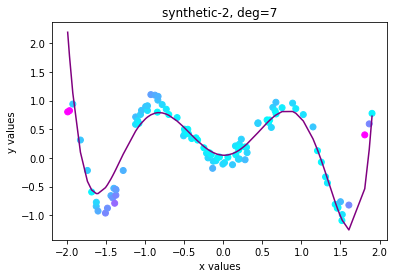

In [40]:
plot(df, poly, degree, name)
#change which df is commented above, and rerun this cell


Above, we see our scatterplot with the polynomial regression curve. Points get darker the further they are from the curve. 